# Integrated Strategy V2.4: True Integration (Diagnostics)

**Phase 4.5 Refinements**:
1.  **Data**: Using `BTCUSDT_2021_2023_1m_features.csv` (Pre-calculated features).
2.  **Leakage Prevention**: Strict `shift(1)` on HTF signals before broadcasting to 1m execution timeframe.
3.  **Target**: Threshold set to **2%** (`0.02`) to balance signal frequency and profit.
4.  **Backtest**: 1m execution with **0.75% fee** per side.
5.  **Signal Logic**: Long if Expected Return > 2% AND Regime is Bull.
6.  **Visualization**: Trade signals overlay on BTC price.
7.  **Diagnostics**: NaN fill checks and Trade Analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
from pathlib import Path
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Add project root to path
project_root = Path('../').resolve()
sys.path.append(str(project_root))

plt.style.use('seaborn-v0_8-darkgrid')

## 1. Load Feature-Rich Data

In [2]:
data_path = project_root / 'data' / 'BTCUSDT_2021_2023_1m_features.csv'
print(f"Loading data from {data_path}...")

# Load data (parsing dates might take a moment for large files)
df = pd.read_csv(data_path)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp').sort_index()

print(f"Data Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

Loading data from E:\Coding\Crypto_Research\data\BTCUSDT_2021_2023_1m_features.csv...
Data Shape: (1534847, 42)
Columns: ['Open', 'High', 'Low', 'Close', 'Volume', 'sma_7d', 'sma_30d', 'sma_90d', 'ema_7d', 'ema_21d', 'adx_14d', 'rsi_14d', 'rsi_30d', 'stoch_k_14d', 'stoch_d_14d', 'macd', 'macd_signal', 'macd_diff', 'rsi_14d_q70', 'rsi_14d_q30', 'rsi_14d_regime', 'bb_mid_20d', 'bb_upper_20d', 'bb_lower_20d', 'atr_14d', 'trend_sma_1d', 'residual_ratio_1d', 'residual_diff_1d', 'trend_sma_7d', 'residual_ratio_7d', 'residual_diff_7d', 'trend_sma_30d', 'residual_ratio_30d', 'residual_diff_30d', 'log_ret', 'volatility_7d', 'volatility_mean_7d', 'volatility_ratio_7d', 'volatility_30d', 'volatility_mean_30d', 'volatility_ratio_30d', 'fd_7d']


## 2. Regime Classification (XGBoost)

In [3]:
# Resample to 4H for Regime Training
# Aggregation logic: OHLC standard, Features take last/mean
agg_dict = {
    'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'Volume': 'sum',
    'rsi_14d': 'last',
    'residual_diff_1d': 'last' 
}

# Handle missing columns gracefully (fallback if specific feature names differ)
available_cols = df.columns.tolist()
final_agg = {k: v for k, v in agg_dict.items() if k in available_cols}
if 'Close' not in final_agg: final_agg['Close'] = 'last'

df_4h = df.resample('4H').agg(final_agg).dropna()

# Feature Engineering (on 4H)
df_4h['Returns'] = df_4h['Close'].pct_change()
df_4h['Vol_20'] = df_4h['Returns'].rolling(20).std()

# Target: > 2% return in next 5 periods (20 hours)
# Lowered from 3% to increase signal frequency while still covering fees
TARGET_THRESHOLD = 0.02
df_4h['Target'] = ((df_4h['Close'].shift(-5) / df_4h['Close'] - 1) > TARGET_THRESHOLD).astype(int)
print(f"Target Threshold: {TARGET_THRESHOLD*100}%")
print(f"Target Distribution:\n{df_4h['Target'].value_counts(normalize=True)}")

df_4h = df_4h.dropna()

# Train/Test Split
split_idx = int(len(df_4h) * 0.8)
train_regime = df_4h.iloc[:split_idx]
test_regime = df_4h.iloc[split_idx:]

# Features for Model
model_features = ['Returns', 'Vol_20']
if 'rsi_14d' in df_4h.columns: model_features.append('rsi_14d')
if 'residual_diff_1d' in df_4h.columns: model_features.append('residual_diff_1d')

print(f"Training XGBoost on features: {model_features}")
model_xgb = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.05, random_state=42)
model_xgb.fit(train_regime[model_features], train_regime['Target'])

# Predict
test_regime = test_regime.copy()
test_regime['Predicted_Regime'] = model_xgb.predict(test_regime[model_features])
print(classification_report(test_regime['Target'], test_regime['Predicted_Regime']))

Target Threshold: 2.0%
Target Distribution:
Target
0    0.809774
1    0.190226
Name: proportion, dtype: float64
Training XGBoost on features: ['Returns', 'Vol_20', 'rsi_14d', 'residual_diff_1d']
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      1143
           1       0.00      0.00      0.00       147

    accuracy                           0.89      1290
   macro avg       0.44      0.50      0.47      1290
weighted avg       0.79      0.89      0.83      1290



## 3. Hybrid Forecasting (Prophet + ARIMA)

In [4]:
# Resample to 1H for Forecasting
df_1h = df.resample('1H').agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'Volume': 'sum'}).dropna()

# Align with Test Period
start_date = test_regime.index[0]
df_forecast = df_1h[df_1h.index >= start_date].copy()

# Train on PREVIOUS data (No leakage)
train_prophet = df_1h[df_1h.index < start_date].reset_index()[['timestamp', 'Close']].rename(columns={'timestamp': 'ds', 'Close': 'y'})

print("Training Prophet...")
model_prophet = Prophet(daily_seasonality=True, yearly_seasonality=False, weekly_seasonality=True)
model_prophet.fit(train_prophet)

future = model_prophet.make_future_dataframe(periods=len(df_forecast), freq='H')
forecast_prophet = model_prophet.predict(future)
trend_pred = forecast_prophet.iloc[-len(df_forecast):]['yhat'].values

residuals = train_prophet['y'] - forecast_prophet.iloc[:-len(df_forecast)]['yhat']
print("Training ARIMA...")
model_arima = ARIMA(residuals, order=(5,0,1)).fit()
resid_pred = model_arima.forecast(steps=len(df_forecast))

df_forecast['Forecast'] = trend_pred + resid_pred.values

# Expected Return (Next Forecast vs Current Close)
df_forecast['Next_Forecast'] = df_forecast['Forecast'].shift(-1)
df_forecast['Expected_Return'] = df_forecast['Next_Forecast'] / df_forecast['Close'] - 1

Training Prophet...


04:19:04 - cmdstanpy - INFO - Chain [1] start processing
04:19:09 - cmdstanpy - INFO - Chain [1] done processing


Training ARIMA...


## 4. Signal Integration (Strict Leakage Prevention)

In [5]:
# 1. Prepare HTF Signals
# Shift(1) ensures we use the signal from the COMPLETED bar
regime_signal = test_regime[['Predicted_Regime']].shift(1)
forecast_signal = df_forecast[['Expected_Return']].shift(1)

# 2. Broadcast to 1m Execution Timeframe
# Reindex to 1m and forward fill to propagate signals across 1m bars
execution_df = df[df.index >= start_date].copy()

# Diagnostic: Check NaNs before fill
nan_regime_before = regime_signal.resample('1min').asfreq().isna().sum().item()
nan_forecast_before = forecast_signal.resample('1min').asfreq().isna().sum().item()

execution_df = execution_df.join(regime_signal.resample('1min').ffill().reindex(execution_df.index, method='ffill'))
execution_df = execution_df.join(forecast_signal.resample('1min').ffill().reindex(execution_df.index, method='ffill'))

# Diagnostic: Check NaNs after fill
nan_regime_after = execution_df['Predicted_Regime'].isna().sum()
nan_forecast_after = execution_df['Expected_Return'].isna().sum()

print(f"NaN Diagnostics:")
print(f"Regime NaNs: Before={nan_regime_before}, After={nan_regime_after}, Filled={nan_regime_before - nan_regime_after}")
print(f"Forecast NaNs: Before={nan_forecast_before}, After={nan_forecast_after}, Filled={nan_forecast_before - nan_forecast_after}")

# Fill remaining NaNs (only at the very start) with 0
execution_df['Predicted_Regime'] = execution_df['Predicted_Regime'].fillna(0)
execution_df['Expected_Return'] = execution_df['Expected_Return'].fillna(0)

# 3. Generate Trade Signal
# Long if Expected Return > 2% (Covers 1.5% Fees + Margin) AND Regime is Bull
# Note: We match the signal threshold to the training target (or slightly lower/higher based on risk appetite)
SIGNAL_THRESHOLD = 0.02
print(f"Signal Threshold: {SIGNAL_THRESHOLD*100}%")

print("Debug - Before Signal Generation:")
print(f"Regime Distribution (Test Period):\n{execution_df['Predicted_Regime'].value_counts()}")
print(f"Expected Return Stats (Test Period):\n{execution_df['Expected_Return'].describe()}")

execution_df['Signal'] = np.where(
    (execution_df['Expected_Return'] > SIGNAL_THRESHOLD) & (execution_df['Predicted_Regime'] == 1),
    1,
    0
)

print("Signal Distribution:")
print(execution_df['Signal'].value_counts())

NaN Diagnostics:
Regime NaNs: Before=310232, After=207, Filled=310025
Forecast NaNs: Before=306489, After=56, Filled=306433
Signal Threshold: 2.0%
Debug - Before Signal Generation:
Regime Distribution (Test Period):
Predicted_Regime
0.0    288030
1.0       240
Name: count, dtype: int64
Expected Return Stats (Test Period):
count    288270.000000
mean          0.258499
std           0.156649
min           0.000000
25%           0.121797
50%           0.215350
75%           0.442260
max           0.555125
Name: Expected_Return, dtype: float64
Signal Distribution:
Signal
0    288030
1       240
Name: count, dtype: int64


## 5. Realistic Backtest

Strategy Net Return: -1.92%
Buy & Hold Return: 51.87%
Sharpe Ratio: -1.96
Max Drawdown: -2.05%

Trade Analysis (First 10 Trades):
                       Close  Predicted_Regime  Expected_Return  Trade_Action  \
timestamp                                                                       
2023-05-29 04:00:00  27950.1               0.0         0.000000           NaN   
2023-08-08 20:00:00  29871.6               1.0         0.210937           1.0   
2023-08-09 00:00:00  29741.6               0.0         0.214798          -1.0   

                     Strategy_Net_Return  
timestamp                                 
2023-05-29 04:00:00                  NaN  
2023-08-08 20:00:00             -0.00750  
2023-08-09 00:00:00             -0.00713  

Trade Stats:
Total Trades: 3
Win Rate: 0.00%
Avg Trade Return: -0.7315%


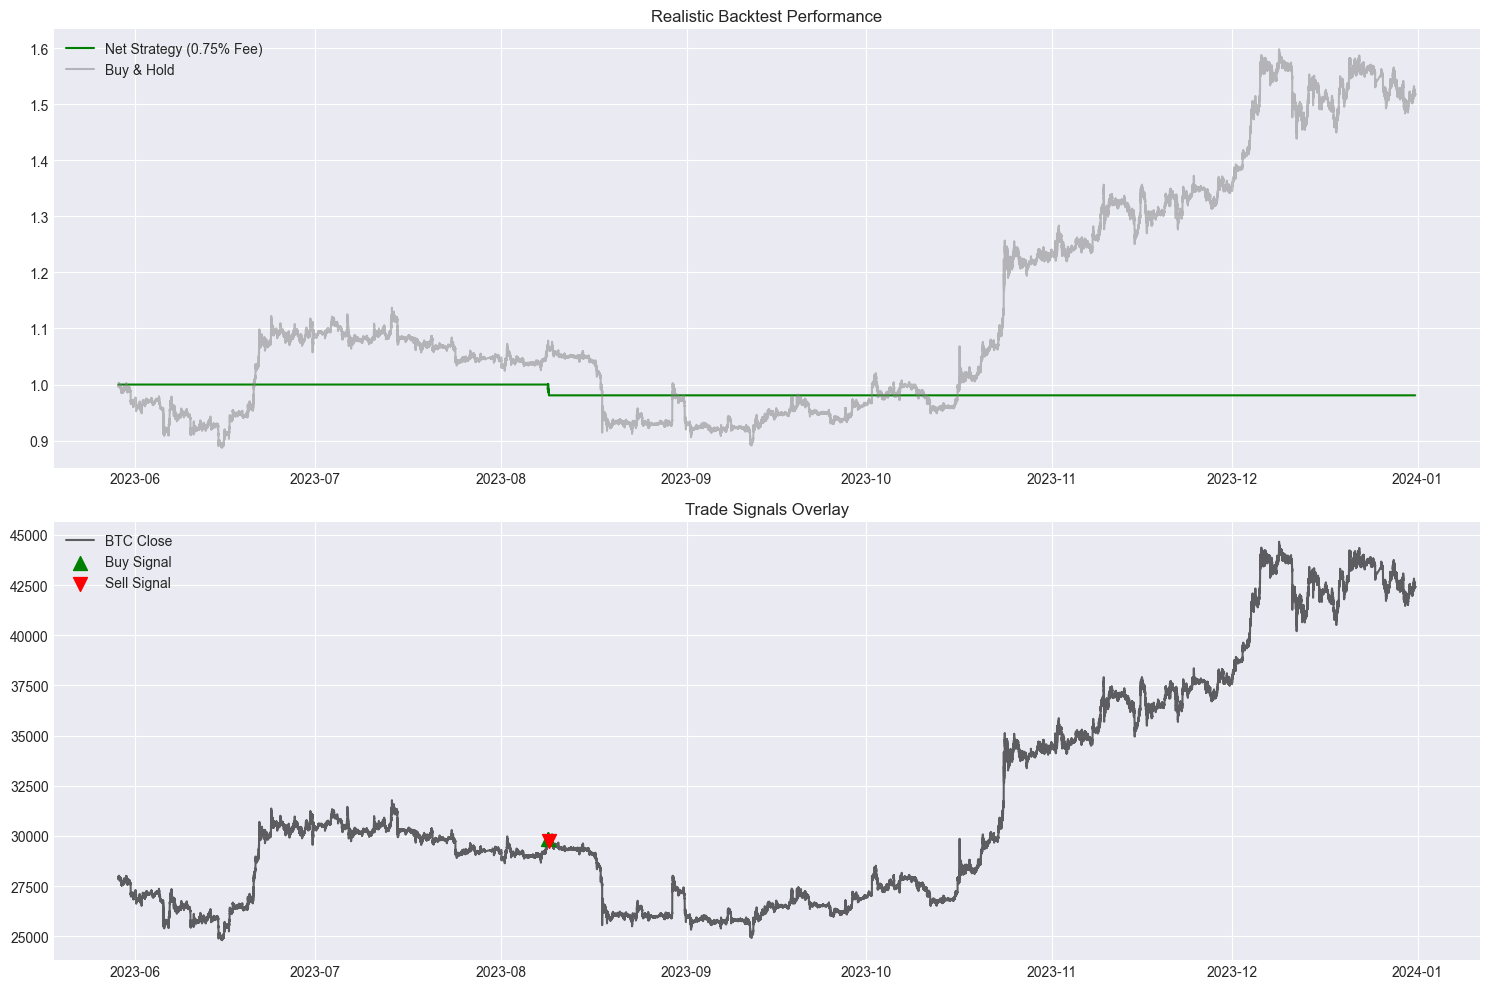

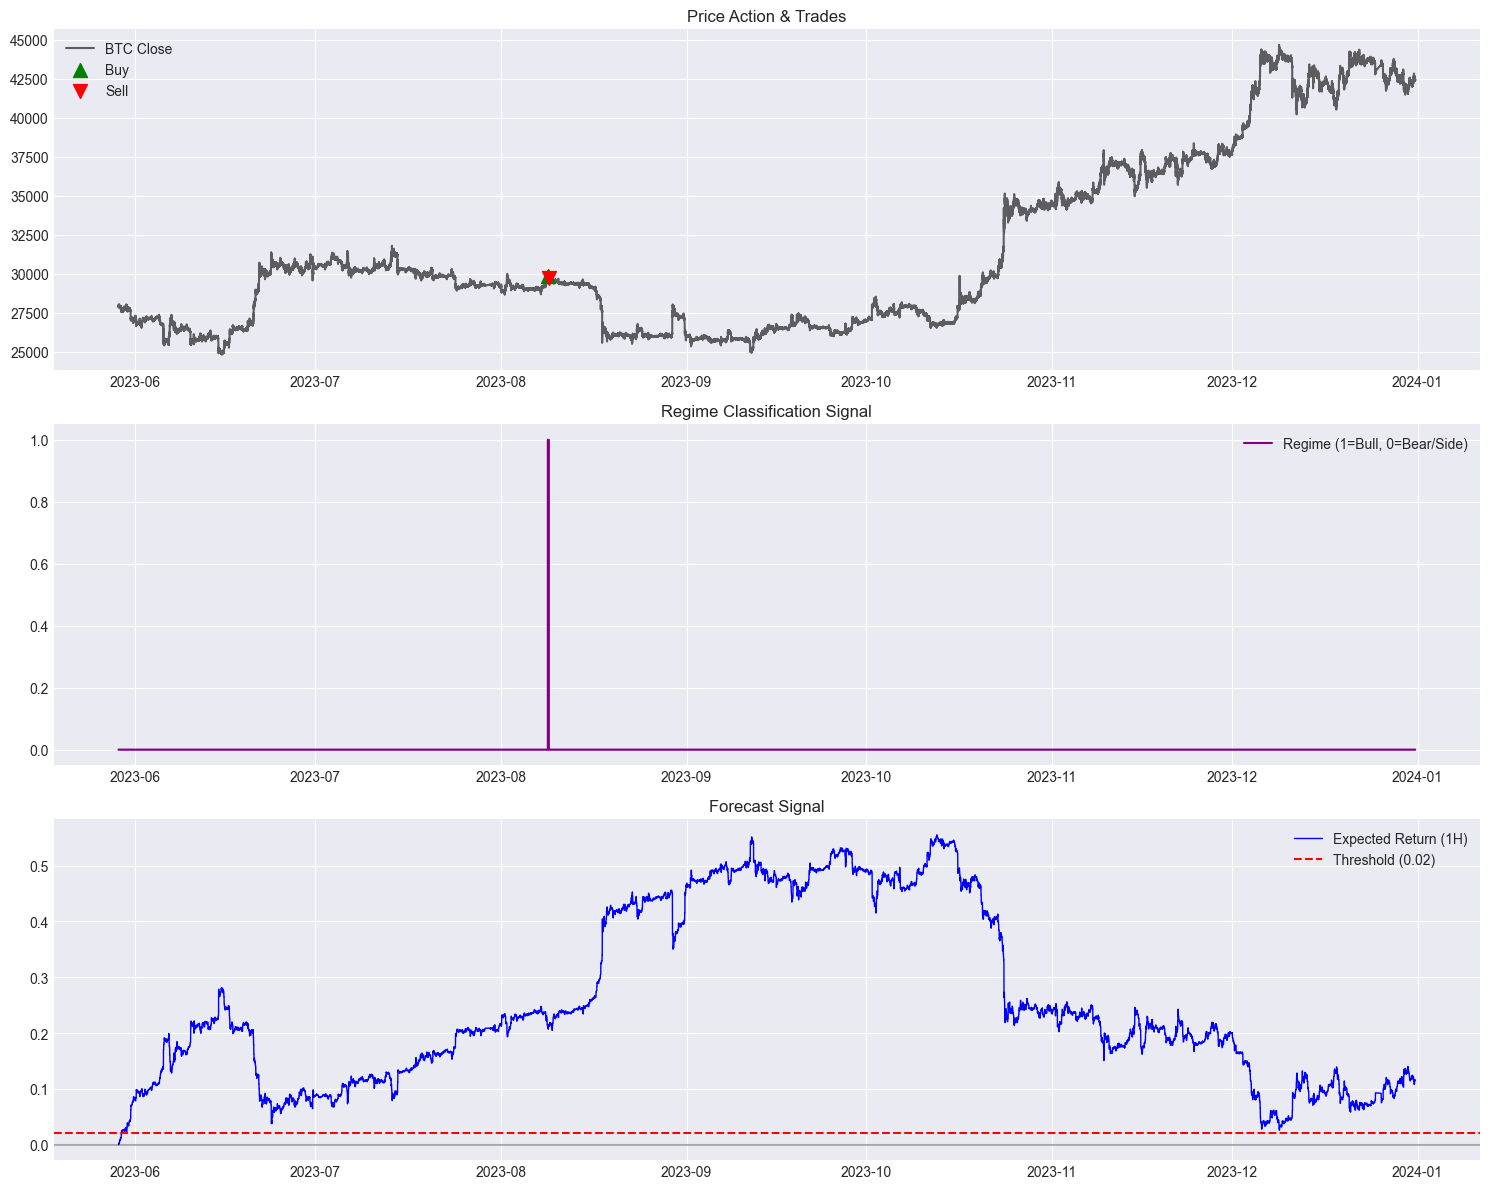

In [6]:
# Parameters
FEE_RATE = 0.0075  # 0.75% per side

# Logic
execution_df['Position'] = execution_df['Signal'] # Assuming we hold as long as signal is 1
execution_df['Trade_Action'] = execution_df['Position'].diff() # 1=Buy, -1=Sell

# Raw Returns
execution_df['Strategy_Raw_Return'] = execution_df['Position'].shift(1) * execution_df['Close'].pct_change()

# Cost Deduction
# Cost is incurred on ANY trade action (Buy or Sell)
execution_df['Cost'] = execution_df['Trade_Action'].abs() * FEE_RATE

# Net Return
execution_df['Strategy_Net_Return'] = execution_df['Strategy_Raw_Return'] - execution_df['Cost'].fillna(0)

# Cumulative
execution_df['Cum_Net_Strategy'] = (1 + execution_df['Strategy_Net_Return']).cumprod()
execution_df['Cum_Buy_Hold'] = (1 + execution_df['Close'].pct_change()).cumprod()

# Metrics
total_return = execution_df['Cum_Net_Strategy'].iloc[-1] - 1
sharpe = execution_df['Strategy_Net_Return'].mean() / execution_df['Strategy_Net_Return'].std() * np.sqrt(365*24*60)
drawdown = execution_df['Cum_Net_Strategy'] / execution_df['Cum_Net_Strategy'].cummax() - 1
max_drawdown = drawdown.min()

print(f"Strategy Net Return: {total_return:.2%}")
print(f"Buy & Hold Return: {execution_df['Cum_Buy_Hold'].iloc[-1] - 1:.2%}")
print(f"Sharpe Ratio: {sharpe:.2f}")
print(f"Max Drawdown: {max_drawdown:.2%}")

# Trade Analysis
trades = execution_df[execution_df['Trade_Action'] != 0]
if not trades.empty:
    print("\nTrade Analysis (First 10 Trades):")
    print(trades[['Close', 'Predicted_Regime', 'Expected_Return', 'Trade_Action', 'Strategy_Net_Return']].head(10))
    print("\nTrade Stats:")
    print(f"Total Trades: {len(trades)}")
    print(f"Win Rate: {(trades['Strategy_Net_Return'] > 0).mean():.2%}")
    print(f"Avg Trade Return: {trades['Strategy_Net_Return'].mean():.4%}")
else:
    print("\nNo trades executed.")

plt.figure(figsize=(15, 10))

# Plot 1: Equity Curve
plt.subplot(2, 1, 1)
plt.plot(execution_df.index, execution_df['Cum_Net_Strategy'], label='Net Strategy (0.75% Fee)', color='green')
plt.plot(execution_df.index, execution_df['Cum_Buy_Hold'], label='Buy & Hold', alpha=0.5, color='gray')
plt.title('Realistic Backtest Performance')
plt.legend()

# Plot 2: Trade Signals Overlay
plt.subplot(2, 1, 2)
plt.plot(execution_df.index, execution_df['Close'], label='BTC Close', alpha=0.6, color='black')

# Identify Buy/Sell points
buys = execution_df[execution_df['Trade_Action'] == 1]
sells = execution_df[execution_df['Trade_Action'] == -1]

plt.scatter(buys.index, buys['Close'], marker='^', color='green', label='Buy Signal', s=100, zorder=5)
plt.scatter(sells.index, sells['Close'], marker='v', color='red', label='Sell Signal', s=100, zorder=5)

plt.title('Trade Signals Overlay')
plt.legend()
plt.tight_layout()
plt.show()

# Signal Component Analysis
plt.figure(figsize=(15, 12))

# Plot 1: Price & Trades (Zoomed in on signals if possible, but here full history)
ax1 = plt.subplot(3, 1, 1)
plt.plot(execution_df.index, execution_df['Close'], label='BTC Close', color='black', alpha=0.6)
plt.scatter(buys.index, buys['Close'], marker='^', color='green', label='Buy', s=100, zorder=5)
plt.scatter(sells.index, sells['Close'], marker='v', color='red', label='Sell', s=100, zorder=5)
plt.title('Price Action & Trades')
plt.legend()

# Plot 2: Regime Signal
ax2 = plt.subplot(3, 1, 2, sharex=ax1)
plt.plot(execution_df.index, execution_df['Predicted_Regime'], label='Regime (1=Bull, 0=Bear/Side)', color='purple', drawstyle='steps-post')
plt.fill_between(execution_df.index, execution_df['Predicted_Regime'], alpha=0.3, color='purple')
plt.title('Regime Classification Signal')
plt.legend()

# Plot 3: Forecast Signal (Expected Return)
ax3 = plt.subplot(3, 1, 3, sharex=ax1)
plt.plot(execution_df.index, execution_df['Expected_Return'], label='Expected Return (1H)', color='blue', linewidth=1)
plt.axhline(y=SIGNAL_THRESHOLD, color='r', linestyle='--', label=f'Threshold ({SIGNAL_THRESHOLD})')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.title('Forecast Signal')
plt.legend()

plt.tight_layout()
plt.show()

## 6. Time-Series Only Strategy (No Regime Filter)

Running Time-Series Only Strategy (No Regime Filter)...
Signal Threshold: 2.0%
Signal Distribution (Time-Series Only):
Signal_TS
1    287671
0       599
Name: count, dtype: int64
Time-Series Strategy Net Return: 42.35%
Sharpe Ratio: 1.95
Max Drawdown: -24.36%


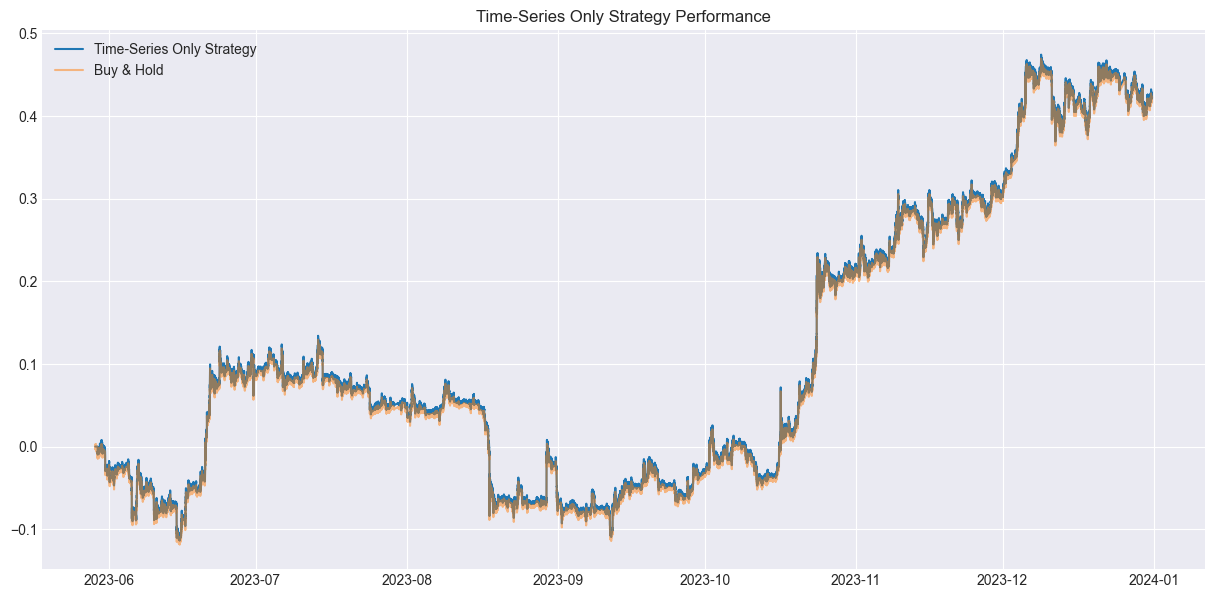

In [7]:
# 6. Time-Series Only Strategy
print("Running Time-Series Only Strategy (No Regime Filter)...")

# Use the same forecast data but ignore the regime signal
# Signal: Long if Expected_Return > 2%
SIGNAL_THRESHOLD = 0.02
print(f"Signal Threshold: {SIGNAL_THRESHOLD*100}%")

execution_df['Signal_TS'] = np.where(
    execution_df['Expected_Return'] > SIGNAL_THRESHOLD,
    1,
    0
)

print("Signal Distribution (Time-Series Only):")
print(execution_df['Signal_TS'].value_counts())

# Backtest
execution_df['Strategy_Return_TS'] = execution_df['Signal_TS'].shift(1) * execution_df['log_ret']

# Apply Fees (0.75% per side)
trades_ts = execution_df['Signal_TS'].diff().abs().fillna(0)
FEE = 0.0075
execution_df['Cost_TS'] = trades_ts * FEE
execution_df['Net_Return_TS'] = execution_df['Strategy_Return_TS'] - execution_df['Cost_TS']

# Performance Metrics
cumulative_return_ts = execution_df['Net_Return_TS'].cumsum()
total_return_ts = cumulative_return_ts.iloc[-1]
sharpe_ratio_ts = execution_df['Net_Return_TS'].mean() / execution_df['Net_Return_TS'].std() * np.sqrt(365*24*60)

# Max Drawdown
rolling_max_ts = cumulative_return_ts.cummax()
drawdown_ts = cumulative_return_ts - rolling_max_ts
max_drawdown_ts = drawdown_ts.min()

print(f"Time-Series Strategy Net Return: {total_return_ts*100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio_ts:.2f}")
print(f"Max Drawdown: {max_drawdown_ts*100:.2f}%")

# Plot
plt.figure(figsize=(15, 7))
plt.plot(cumulative_return_ts.index, cumulative_return_ts, label='Time-Series Only Strategy')
plt.plot(execution_df.index, execution_df['log_ret'].cumsum(), label='Buy & Hold', alpha=0.5)
plt.title('Time-Series Only Strategy Performance')
plt.legend()
plt.show()